In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
#Inspect Meansurement table to see if it has date column
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [16]:
station_columns = inspector.get_columns("station")
for c in station_columns:
    print(c["name"],c["type"])

#now we know that the date column to query exists in the measurement table of the hawaii sqlite file

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()

print(most_recent_date)

('2017-08-23',)


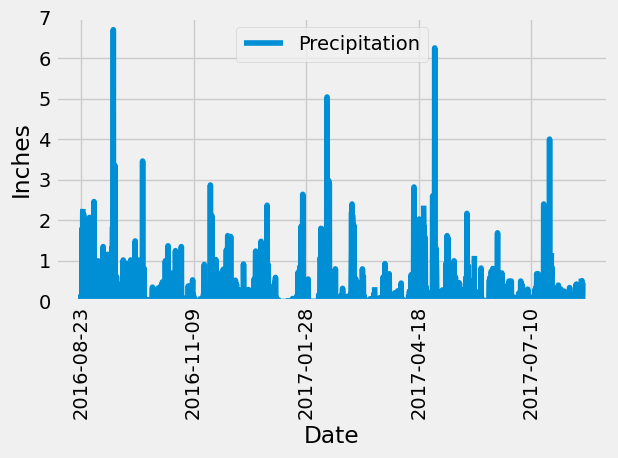

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

selection_coloums = [measurement.date, measurement.prcp]

# Calculate the date one year from the last date in data set.
date_year_before = (dt.strptime(most_recent_date[0], "%Y-%m-%d") - relativedelta(days = 366)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
query_results = session.query(*selection_coloums).filter(measurement.date > date_year_before).\
                order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(query_results)
prcp_df = prcp_df.rename(columns={"date": "Date", "prcp": "Precipitation"})
prcp_df = prcp_df.set_index("Date")

# Sort the dataframe by date
# even though query results are sorted by ascending date, sorting again in dataframe
prcp_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.ylim(0,7)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [72]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
#total_number_stations= session.query(station.station).count()
session.query(func.count(station.id)).all()


[(9,)]

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_counts = func.count(measurement.station)

active_stations = session.query(measurement.station,station_counts).\
    order_by(station_counts.desc()).\
    group_by(measurement.station).all() 

active_stations 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


- **Station 'USC00519281' has the most number of observations. Observation count is 2772.**

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stnumber = active_stations[0][0]

selection = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
mostactivestationdata = session.query(*selection).\
    filter(measurement.station == most_active_stnumber).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()

mostactivestationdata



[(54.0, 85.0, 71.66378066378067)]

(0.0, 70.0)

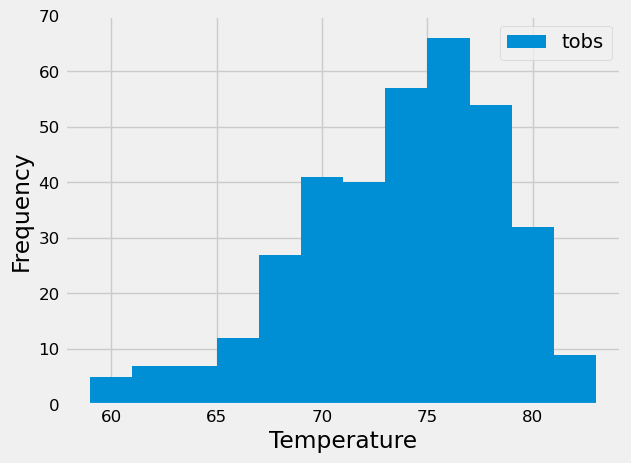

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Most recent date for the most active station
most_recent_date_st = session.query(measurement.date).filter(measurement.station == most_active_stnumber).\
                      order_by(measurement.date.desc()).first()

# Calculate the date one year from the most recent date for the given station.
date_year_before_st = (dt.strptime(most_recent_date_st[0], "%Y-%m-%d") - relativedelta(days = 366)).strftime("%Y-%m-%d")

# Create query to fetch dates and temperature observations for most active station for the last 12 months
twelve_month_values = session.query(measurement.tobs).\
    filter(measurement.station == most_active_stnumber).\
    filter(measurement.date > date_year_before_st).all()

# Create list from the query's result to use for plotting histogram
tobs_values = list(np.ravel(twelve_month_values))

plt.hist(tobs_values,bins=12,label='tobs') 
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)
plt.show()

# Close Session

In [136]:
# Close Session
session.close()